# Final Project
## Pricing Agency MBS

1. Interest rate model
    - We used CIR interest rate model to generate our interest rate path. The simulation contained 5000 paths which we averaged then to get the discount factor.
    - Parameter choosing: In CIR model, there are three parameters: adjusting speed kappa, mean b, volatility sigma. Also, we need to choose a starting point for short rate, r0. To better simulate the interest rate progress, we used the parameter given by applying MLE estimation on LIBOR for the short-term 3 months. For the starting point, we used Fama French data to get the daily risk free rate.
2. Prepayment model
    - We used PSA model (100 PSA) and Bloomberg prepayment model as two prepayment models.
    


### 1. PSA model
Our desinated MBS(FG A17571) was issued at 01/01/2004 and its maturity date is 12/01/2033, so its remaining life is 150 months.

For prepayment rate calculation, the conditional prepayment rate will keep constant as 0.06 in its remaining life.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
# MBS information
wac = 0.0475
crt_balance = 495818

period = 150 # remaining months
ndays = int(period * 30) # days

# Interest rate model parameters
r0 = 0.006
r_bar = 0.06
sigma = 0.14
kappa = 0.44

In [89]:
# Monte Carlo similation of CIR model
def mcCIR(r0, kappa, r_bar, sigma, period, simulations=5000):
    np.random.seed(1)
    ndays = int(period * 30)
    dt = 1/360.
    
    cir_mat = np.zeros((simulations, ndays + 1))
    cir_mat[:,0] = r0
    for i in range(1, ndays + 1):
        brownian = np.random.standard_normal(simulations)
        cir_mat[:,i] = cir_mat[:,i-1] + kappa * (r_bar -cir_mat[:,i-1]) * dt + sigma * brownian * np.sqrt(dt * cir_mat[:,i-1])
    
    step = 30 * np.arange(1, period + 1, 1)
    R_cir = [dt * np.sum(cir_mat[:,1:j], axis = 1) for j in step]
    
    return R_cir

In [90]:
def MBS_PSA(wac, period, notional, R_cir):
    np.random.seed(1)
    ndays = int(period * 360)
    dt = 1/360.
    rm = wac/12. # monthly coupon
    
    PV = [notional]
    c = []
    # CPR = np.arange(0.002, 0.002*(30+1), 0.002)
    # CPR = np.append(CPR, np.repeat(CPR[-1], period - 30))
    CPR = np.repeat(0.06, period)

    for i in range(period):
        IP = PV[-1] * rm # interest payment
        SP = PV[-1] * rm *(1/(1 - pow(1+rm, -period + i)) - 1.) #scheduled payment
        PP = (PV[-1] - SP)*(1 - pow(1 - CPR[i], 1/12.)) # prepayment
        PV_i = PV[-1] - SP - PP # outstanding balance
        PV.append(PV_i)
        c.append(IP + SP + PP) # cashflow
    
    plt.plot(c)
    plt.xlabel("Period")
    plt.ylabel("Cash Flow")
    plt.title("Cash Flow before discounted")
    plt.show()
    
    disc = [np.mean(np.exp(-R_cir[i])) for i in range(period)]
    MBS = np.dot(disc, c)
    
    return MBS

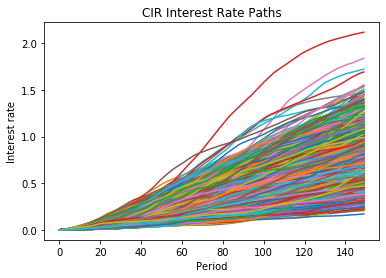

In [91]:
R_cir = mcCIR(r0, kappa, r_bar, sigma, period, simulations=5000)
plt.plot(R_cir)
plt.xlabel("Period")
plt.ylabel("Interest rate")
plt.title("CIR Interest Rate Paths")
plt.show()

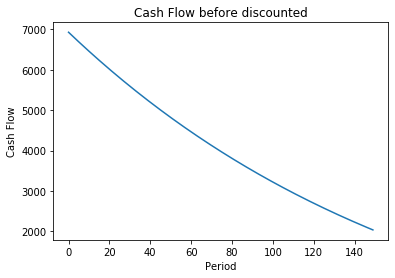

The price of MBS under CIR model(kappa = 0.3) is: 513411.32425709744


In [92]:
sol_mbs = MBS_PSA(wac, period, crt_balance, R_cir)
print("The price of MBS under CIR model(kappa = 0.3) is:", sol_mbs)

## 2. Bloomberg Prepayment Model

For this prepayment methond, we downloaded the cash flow data from bloomberg terminal and just discounted it.

In [93]:
data = pd.read_csv('BPM.csv')
data = data[1:]
data.head()

,Dates,Balance,Sched,Unsched,Interest,Cashflow,Coupon
1,04/15/2020,478901.0,2379,4783,1823,8985,4.5
2,05/15/2020,471118.0,2365,5419,1796,9580,4.5
3,06/15/2020,463073.0,2347,5697,1767,9811,4.5
4,07/15/2020,454201.0,2328,6544,1737,10609,4.5
5,08/15/2020,445515.0,2304,6383,1703,10390,4.5


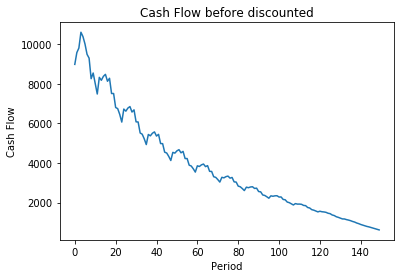

In [94]:
c = data.Cashflow.values

plt.plot(c)
plt.xlabel("Period")
plt.ylabel("Cash Flow")
plt.title("Cash Flow before discounted")
plt.show()

disc = [np.mean(np.exp(-R_cir[i])) for i in range(len(data))]
MBS = np.dot(disc, c)

In [95]:
print("The price of MBS under BPM model is:", MBS)

The price of MBS under BPM model is: 499478.6766435004


# Pricing non-agency MBS
We used conditional default rate(CDR) to measure defaults. This method is introduced in Chapter 13 of our textbook (P. 309). Below is a graph of the CDR in its whole life. However, since this MBS only has 150 months to mature, the CDR also keeps constant as 0.03%. 

In [96]:
def nonagency_MBS_PSA(wac, period, notional, R_cir):
    np.random.seed(1)
    ndays = int(period * 30)
    dt = 1/360.
    rm = wac/12. # monthly coupon
    
    PV = [notional]
    c = []
    # CPR = np.arange(0.002, 0.002*(30+1), 0.002)
    # CPR = np.append(CPR, np.repeat(CPR[-1], period - 30))
    CPR = np.repeat(0.06, period)
    
    # 100 SDA
    CDR_w = np.arange(0.0002, 0.0002*(30+1), 0.0002)
    CDR_w = np.append(CDR_w, np.repeat(CDR_w[-1], 30))
    CDR_w = np.append(CDR_w, np.arange(0.006, 0.0003-0.000095, -0.000095))
    CDR_w = np.append(CDR_w, np.repeat(CDR_w[-1], 30*12 - 120))
    
    plt.plot(CDR_w)
    plt.xlabel("Period")
    plt.ylabel("CDR")
    plt.title("Conditional Defaulted Rate in MBS's whole life")
    plt.show()
    
    CDR = np.repeat(0.0003, period)
    
    for i in range(period):
        IP = PV[-1] * rm # interest payment
        SP = PV[-1] * rm *(1/(1 - pow(1+rm, -period + i)) - 1.) #scheduled payment
        PP = (PV[-1] - SP)*(1 - pow(1 - CPR[i], 1/12.)) # prepayment
        DP = (PV[-1] - SP)*(1 - pow(1 - CDR[i], 1/12.)) # defaulted loan
        PV_i = PV[-1] - SP - PP # outstanding balance
        PV.append(PV_i)
        c.append(IP + SP + PP - DP) # cashflow

    plt.plot(c)
    plt.xlabel("Period")
    plt.ylabel("Cash Flow")
    plt.title("Cash Flow before discounted")
    plt.show()
    
    disc = [np.mean(np.exp(-R_cir[i])) for i in range(period)]
    MBS = np.dot(disc, c)
    
    return MBS

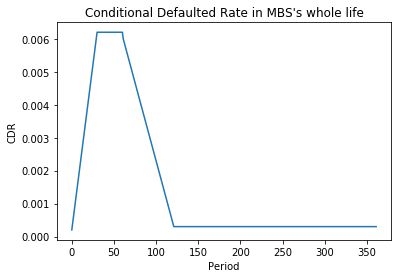

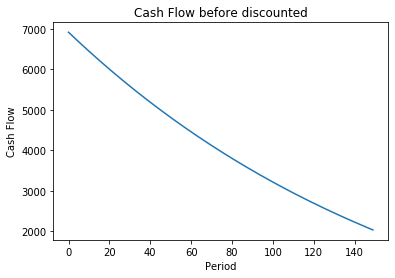

The price of nonagency MBS under CIR model(kappa = 0.3) is: 512721.6262556014


In [97]:
sol_nonmbs = nonagency_MBS_PSA(wac, period, crt_balance, R_cir)
print("The price of nonagency MBS under CIR model(kappa = 0.3) is:", sol_nonmbs)

In [100]:
print("The price of MBS under CIR model(kappa = 0.3) is:", sol_mbs/crt_balance*100)
print("The price of MBS under BPM model is:", MBS/crt_balance*100)
print("The price of nonagency MBS under CIR model(kappa = 0.3) is:", sol_nonmbs/crt_balance*100)

The price of MBS under CIR model(kappa = 0.3) is: 103.54834319389322
The price of MBS under BPM model is: 100.73831055820894
The price of nonagency MBS under CIR model(kappa = 0.3) is: 103.40924013561457


## Conclusion

- We could see from the result that two different prepayment models gave different current price for one MBS. The price given by bloomberg prepayment model is a little bit lower than PSA model's.

- For the difference between agency MBS and non-agency MBS, we could find that the MBS with default possibility had a relatively lower price. But for this case, the difference was not that much probably because remaining life was around 13 years and the default rate was only 0.03%.

- Also, we noticed that the prices given by our calculation are lower than the true current price(around 109). The differences might be caused by our interest rate model. 